In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
import sklearn.impute as impute
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import sklearn.metrics as metrics
import matplotlib.pyplot as pl
import io
import base64

In [12]:
def convert():
    pl.show()
    img_io = io.BytesIO()  # io字节流
    pl.savefig(img_io, format='png')  # 将图形保存为 png 格式，并将图像数据写入到 img_io对象中。
    img_io.seek(0)  # 将文件指针移动到图像数据的开头位置
    img_base64 = base64.b64encode(img_io.getvalue()).decode('utf-8')  # 将图像流转换为 Base64 编码的字符串
    image = {'image': img_base64}  # 将图像保存为 Base64 编码的字符串字典
    pl.close()  # 清空内存
    return image

In [13]:
def data_load(path):
    df = pd.read_csv(path)
    sample_id = df['sample_id'].values
    features = df.loc[:, 'feature0':'feature106'].values
    label = df['label'].values
    return sample_id, features, label


def data_load_test(path):
    df = pd.read_csv(path)
    sample_id = df['sample_id'].values
    features = df.loc[:, 'feature0':'feature106'].values
    return sample_id, features

In [14]:
def train_pre_process_1(X, y):
    Impute = impute.SimpleImputer(strategy="most_frequent")
    Impute.fit(X)
    X = Impute.transform(X)

    classifier = ExtraTreesClassifier(n_estimators=70, random_state=42, n_jobs=-1)
    classifier = classifier.fit(X, y)
    selection_model = SelectFromModel(classifier, prefit=True, threshold='1.5*mean')

    X = selection_model.transform(X)
    print(X.shape)
    return X, y, selection_model


def train_pre_process_2(X, y):
    Impute = impute.SimpleImputer(strategy="most_frequent")
    Impute.fit(X)
    X = Impute.transform(X)

    classifier = ExtraTreesClassifier(n_estimators=70, random_state=42, n_jobs=-1)
    classifier = classifier.fit(X, y)
    selection_model = SelectFromModel(classifier, prefit=True, threshold='1.85*mean')

    X = selection_model.transform(X)
    print(X.shape)
    return X, y, selection_model



def valid_pre_process(X, selection_model):
    Impute = impute.SimpleImputer(strategy="most_frequent")
    Impute.fit(X)
    X = Impute.transform(X)
    X = selection_model.transform(X)
    print(X.shape)
    return X


def test_pre_process(X, selection_model):
    imputer = impute.SimpleImputer(strategy="most_frequent")
    imputer.fit(X)
    X = imputer.transform(X)
    X = selection_model.transform(X)
    print(X.shape)
    return X


def plot_matrix(y_true, y_pred, labels_name, title=None, thresh=0.8, axis_labels=None):
    cm = metrics.confusion_matrix(y_true, y_pred, labels=labels_name, sample_weight=None)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    pl.imshow(cm, interpolation='nearest', cmap=pl.get_cmap('Blues'))
    pl.colorbar()

    if title is not None:
        pl.title(title)
    num_local = np.array(range(len(labels_name)))
    if axis_labels is None:
        axis_labels = labels_name
    pl.xticks(num_local, axis_labels)
    pl.yticks(num_local, axis_labels)
    pl.ylabel('True label')
    pl.xlabel('Predicted label')

    for i in range(np.shape(cm)[0]):
        for j in range(np.shape(cm)[1]):
            if int(cm[i][j] * 100 + 0.5) > 0:
                pl.text(j, i, format(int(cm[i][j] * 100 + 0.5), 'd') + '%',
                        ha="center", va="center",
                        color="white" if cm[i][j] > thresh else "black")
    matrix = convert()

In [15]:
def result(y_true, y_pred):
    # 分类评估报告
    report = metrics.classification_report(y_true, y_pred, output_dict=False)
    print(report)
    # 混淆矩阵
    matrix = plot_matrix(y_true, y_pred, [0, 1, 2, 3, 4, 5], title='confusion_matrix',
                         axis_labels=['0', '1', '2', '3', '4', '5'])
    # result = {**report, **matrix}

In [16]:
class Classifier:
    # 类初始化
    def __init__(self, module, param_grid):
        self.selection_model = None
        self.param_grid = param_grid
        self.module = module

    def train(self, X, y):
        self.rfc_cv = GridSearchCV(estimator=self.module, param_grid=self.param_grid, scoring='f1_macro',
                                   cv=5)  # 5折交叉验证
        self.rfc_cv.fit(X, y)

    def predict(self, X):
        y_pred = self.rfc_cv.predict(X)
        # 预测结果转字典
        y_pred_dict = {str(index): int(value) for index, value in enumerate(y_pred)}

        unique_labels = set(y_pred)
        counts = [sum(y_pred == label) for label in unique_labels]  # 计算每个分类的样本数量
        labels = [f"Class {label}" for label in unique_labels]  # 创建分类标签的字符串列表
        colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple']

        # 绘制分类结果饼状图
        def autopct_format(value):
            return f'{value:.1f}% ({int(value * sum(counts) / 100)})'

        pl.title("Classification Result")
        pl.pie(x=counts, labels=labels, colors=colors, autopct=autopct_format, startangle=90)
        pl.axis('equal')  # 设置纵横比为相等

        # 柱状图 Base64 编码字符串json
        barImage = convert()
        # 合并结果
        result = {**y_pred_dict, **barImage}
        return result

    def test(self, X):
        y_pred = self.rfc_cv.predict(X)
        return y_pred

In [17]:
res = Classifier(RandomForestClassifier(), param_grid={
    'criterion': ['gini'],
    'max_depth': [17],
    'n_estimators': [200],
    'max_features': ['sqrt'],
    'min_samples_split': [30],
    'class_weight': ['balanced'],
    'oob_score': [True],
    'random_state': [42],
    'n_jobs': [-1]
})

In [18]:
sample_id, features, label = data_load(path="../data_new/train_10000.csv")
sample_id_v, features_v, label_v = data_load(path="../data_new/validate_1000.csv")

(10000, 16)
(1000, 16)
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       176
           1       0.60      0.98      0.74       166
           2       0.91      0.28      0.43       171
           3       0.98      0.98      0.98       169
           4       0.97      0.99      0.98       156
           5       0.99      0.93      0.96       162

    accuracy                           0.84      1000
   macro avg       0.88      0.85      0.83      1000
weighted avg       0.88      0.84      0.82      1000



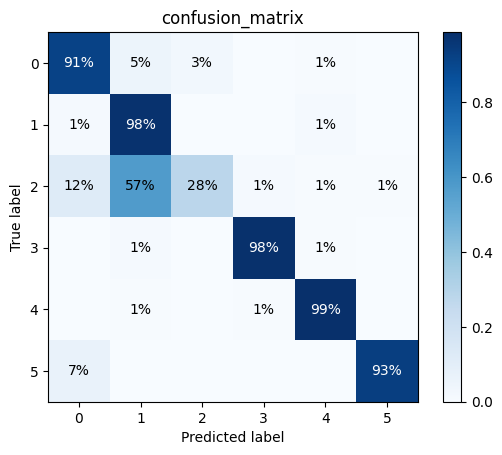

In [19]:
X_train, y_train, selection_model = train_pre_process_1(features, label)
res.train(X_train, y_train)

X_test = valid_pre_process(features_v, selection_model)
y_true = label_v
y_pred = res.test(X_test)
result(y_true, y_pred)

(2675, 6)
(325, 6)
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       176
           1       0.84      0.81      0.83       166
           2       0.78      0.75      0.77       171
           3       0.98      0.98      0.98       169
           4       0.97      0.99      0.98       156
           5       0.99      0.93      0.96       162

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



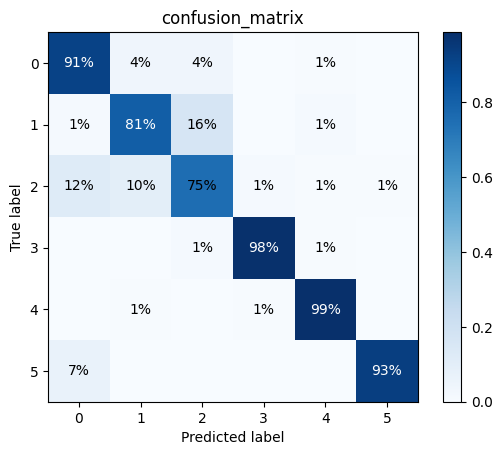

In [20]:
# 1 2训练集
category_filter_1 = np.isin(label, [1, 2])  # 过滤器
X_filtered_1 = features[category_filter_1]
y_filtered_1 = label[category_filter_1]
X_train_1, y_train_1, selection_model_1 = train_pre_process_2(X_filtered_1, y_filtered_1)
res.train(X_train_1, y_train_1)

# 1 2验证集
category_filter_2 = np.isin(y_pred, [1, 2])
X_filtered_2 = features_v[category_filter_2]
y1_true_1 = label_v[category_filter_2]
X_1 = valid_pre_process(X_filtered_2, selection_model_1)
y1_pred_1 = res.test(X_1)

category_filter_3 = np.isin(y_pred, [0, 3, 4, 5])
y2_pred_1 = y_pred[category_filter_3]
y2_true_1 = label_v[category_filter_3]

# 合并结果
y_pred_1 = np.concatenate((y1_pred_1, y2_pred_1))
y_true_1 = np.concatenate((y1_true_1, y2_true_1))
result(y_true_1, y_pred_1)

In [21]:
for key in res.rfc_cv.best_params_.keys():
    print('%s = %s' % (key, res.rfc_cv.best_params_[key]))  # 参数形成json返回

class_weight = balanced
criterion = gini
max_depth = 17
max_features = sqrt
min_samples_split = 30
n_estimators = 200
n_jobs = -1
oob_score = True
random_state = 42
